# Recommendation Systems

# Context :

Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

# Data Description :

Data columns- First three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

# Problem Statement :

To make a recommendation system that recommends at least 5 new products based on the user's habits.

## Importing relevent libraries and reading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
raw_data = pd.read_csv('ratings_Electronics.csv',names=['userId', 'productId','Rating','timestamp'])

In [3]:
# Taking the 10% Data as the Data is Huge and was cluttering the memory

data =  raw_data.iloc[:782448]

In [4]:
data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [6]:
data.shape

(782448, 4)

In [7]:
# Dropping the Timestamp feature as it doesnt add much value to the model

data = data.drop(['timestamp'], axis = 1)

In [8]:
data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [10]:
# finding minimum and maximum ratings

print('The minimum rating is: %d' %(data['Rating'].min()))
print('The maximum rating is: %d' %(data['Rating'].max()))

The minimum rating is: 1
The maximum rating is: 5


In [11]:
data.groupby('userId')['Rating'].mean().sort_values(ascending=False).head(10)  

userId
A2W4G6C7I84MS9    5.0
A1O6EQJ9A2MV9Z    5.0
A1O6F2TRUAGBFD    5.0
A3DO545GPBJQVL    5.0
A3DO6B80J60641    5.0
A1O6F1HAFWJCX2    5.0
A3DO6XO8WQYRF5    5.0
A3DO6YJ87GYC3G    5.0
A3DO8PUU4DLF6W    5.0
A3DO9VJHDA9D8B    5.0
Name: Rating, dtype: float64

C:\Users\Sumit Gupta\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


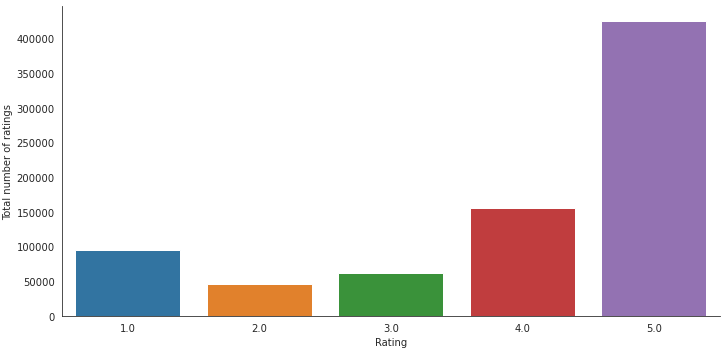

In [12]:
# Checking the Rating distribution in the range 1-5 for the Data given 

with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [16]:
print("Total data ")
print('*'*50)
print("\nTotal no of ratings :",data.shape[0])
print("Total No of Users   :", len(np.unique(data.userId)))
print("Total No of products  :", len(np.unique(data.productId)))

Total data 
**************************************************

Total no of ratings : 782448
Total No of Users   : 606149
Total No of products  : 47105


In [20]:
#Keeping the users where the user has rated more than 50 

counts1 = data['userId'].value_counts()
#print(counts1)
data_new = data[data['userId'].isin(counts1[counts1 >= 50].index)]
#counts1

In [21]:
#Printing highest rated products from the selected records. 

data_new.groupby('productId')['Rating'].mean().sort_values(ascending=False) 

productId
B00004Y284    5.0
B0000513SA    5.0
B000068BRE    5.0
B0000DJEIP    5.0
B00007J8SB    5.0
             ... 
B0001LGXO0    1.0
B0001PFO3C    1.0
B0001WNKBI    1.0
B0001X6GEK    1.0
1400532655    1.0
Name: Rating, Length: 2207, dtype: float64

In [22]:
#Calculating the density of the rating matrix

final_ratings_matrix = data_new.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (27, 2207)
given_num_of_ratings =  2550
possible_num_of_ratings =  59589
density: 4.28%


In [26]:
final_ratings_matrix.head()

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA,B000BTL0OA,B000BTPVHW,B000BTQXUG
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1FR68QH6Z4YZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF

final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A11D1KHM7DVOQK,A12DLJESJKM1OQ,A149RNR5RH19YY,A1F9Z42CFF9IAY,A1FR68QH6Z4YZM,A1JWSDDIH5Z7DV,A1MJMYLRTZ76ZX,A1RPTVW5VEOSI,A203OCQQ12MAVT,A231WM2Z2JL0U3,...,A3OXHLG6DIBRW8,A5JLAU2ARJ0BO,A6FIAB28IS79,A7Y6AVS576M03,ABH9D1TEOJ56E,AGHZXQL9F94T9,AGXV8E7XK9J6H,AKT8TGIT6VVZ5,AT2J7H5TRZM8Z,AT6CZDCP4TRGA
productId,,,,,,,,,,,,,,,,,,,,,
1400532655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000000O48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000001OL6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000001OMN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000J05A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Building Popularity Recommender Model

In [28]:
#Counting of user_id for each unique product as recommendation score 

data_new_grouped = data_new.groupby('productId').agg({'userId': 'count'}).reset_index()
data_new_grouped.rename(columns = {'userId': 'score'},inplace=True)
data_new_grouped.head()

,productId,score
0,1400532655,1
1,B000000O48,1
2,B000001OL6,1
3,B000001OMN,1
4,B00000J05A,1


In [29]:
#Sorting the products on recommendation score 
train_data_sort = data_new_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generating a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Getting the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
113,B00004SB92,6,1.0
1099,B00008OE6I,5,2.0
368,B00005AW1H,4,3.0
612,B0000645C9,4,4.0
976,B00007KDVI,4,5.0


In [30]:
# Using popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Adding user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bringing user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [32]:
find_recom = [15,21,53]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

Here is the recommendation for the userId: 15

      userId   productId  score  Rank
113       15  B00004SB92      6   1.0
1099      15  B00008OE6I      5   2.0
368       15  B00005AW1H      4   3.0
612       15  B0000645C9      4   4.0
976       15  B00007KDVI      4   5.0


Here is the recommendation for the userId: 21

      userId   productId  score  Rank
113       21  B00004SB92      6   1.0
1099      21  B00008OE6I      5   2.0
368       21  B00005AW1H      4   3.0
612       21  B0000645C9      4   4.0
976       21  B00007KDVI      4   5.0


Here is the recommendation for the userId: 53

      userId   productId  score  Rank
113       53  B00004SB92      6   1.0
1099      53  B00008OE6I      5   2.0
368       53  B00005AW1H      4   3.0
612       53  B0000645C9      4   4.0
976       53  B00007KDVI      4   5.0




<ipython-input-30-a6f375d987c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['userId'] = user_id
<ipython-input-30-a6f375d987c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['userId'] = user_id
<ipython-input-30-a6f375d987c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

### Observations :

If we see all the recommendations for all the users are the same. It is not user dependent for one which look for recommendations.

The user iD level recommendation and the general recommedation are the same.

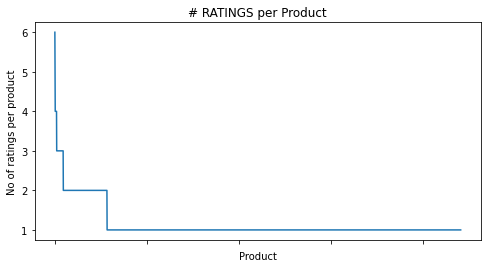

In [33]:
no_of_ratings_per_product = data_new.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

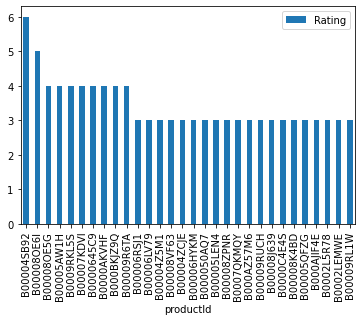

In [34]:
# Top 30 recommendations for the users

popular_products = pd.DataFrame(data_new.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

### Observations :

Since this is a popularity-based recommender model, recommendations remain the same for all users which we have given in the input

We predict the products based on the popularity. It is not personalized to particular user.

## Collaborative Filtering using kNN

In [36]:
from surprise import Reader

In [37]:
#Reading the dataset

reader = Reader(rating_scale=(1, 5))
data1 = Dataset.load_from_df(data_new,reader)
data1

In [38]:
#Splitting the dataset

trainset, testset = train_test_split(data1, test_size=0.3,random_state=10)

# Observations :

1) Trainset is no longer a pandas dataframe. Rather, it's a specific datatypes defined by the Surprise library

2) UserID and product ID in the pandas dataframe can contain any value (either string/integer etc). However, Trainset convert these raw ids into numeric indexes called as "inner id"

In [39]:
trainset.ur

defaultdict(list,
            {0: [(0, 4.0),
              (10, 5.0),
              (50, 1.0),
              (64, 4.0),
              (70, 4.0),
              (85, 4.0),
              (96, 3.0),
              (112, 4.0),
              (121, 4.0),
              (145, 4.0),
              (177, 4.0),
              (185, 5.0),
              (214, 4.0),
              (216, 3.0),
              (231, 4.0),
              (234, 1.0),
              (241, 2.0),
              (249, 3.0),
              (255, 4.0),
              (262, 5.0),
              (343, 1.0),
              (345, 5.0),
              (347, 1.0),
              (353, 2.0),
              (364, 2.0),
              (414, 3.0),
              (422, 4.0),
              (449, 4.0),
              (484, 3.0),
              (490, 4.0),
              (499, 2.0),
              (521, 4.0),
              (526, 4.0),
              (529, 5.0),
              (590, 2.0),
              (628, 2.0),
              (629, 4.0),
              (659, 2.0),

In [40]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering

algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [41]:
# run the trained model against the testset

test_pred = algo.test(testset)

In [47]:
test_pred

[Prediction(uid='A25HBO5V8S8SEA', iid='B0000DK3I4', r_ui=5.0, est=4.197759103641457, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1F9Z42CFF9IAY', iid='B00001WRSJ', r_ui=2.0, est=4.197759103641457, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1MJMYLRTZ76ZX', iid='B00004YZLV', r_ui=5.0, est=4.608695652173913, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B0007KQWF0', r_ui=5.0, est=4.197759103641457, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00008BO91', r_ui=5.0, est=4.197759103641457, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00006HCCS', r_ui=5.0, est=3.9660377358490564, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AT2J7H5TRZM8Z', iid='B00006JM1W', r_ui=4.0, est=4.197759103641457

In [48]:
from collections import defaultdict

def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [49]:
top_n = get_top_n(test_pred, n=5)

In [50]:
top_n

defaultdict(list,
            {'A25HBO5V8S8SEA': [('B0000691IO', 5),
              ('B00005ICE1', 5),
              ('B00007KDVI', 4.975806451612903),
              ('B00006HCHH', 4.975806451612903),
              ('B00006HXF4', 4.975806451612903)],
             'A1F9Z42CFF9IAY': [('B00001WRSJ', 4.197759103641457),
              ('B000BJSEQW', 4.197759103641457),
              ('B00007E7QS', 4.197759103641457),
              ('B00078GLJY', 4.197759103641457),
              ('B00007H08Y', 4.197759103641457)],
             'A1MJMYLRTZ76ZX': [('B00004YZLV', 4.608695652173913),
              ('B00007B6L5', 4.608695652173913),
              ('B00005NHH8', 4.608695652173913),
              ('B000031KIM', 4.608695652173913),
              ('B000BKJZ9Q', 4.608695652173913)],
             'A5JLAU2ARJ0BO': [('B00008OE6I', 4.262334032145352),
              ('B0007KQWF0', 4.197759103641457),
              ('B00008BO91', 4.197759103641457),
              ('B00006HYWR', 4.197759103641457),
         

In [51]:
# Print the recommended items for each user

for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A25HBO5V8S8SEA ['B0000691IO', 'B00005ICE1', 'B00007KDVI', 'B00006HCHH', 'B00006HXF4']
A1F9Z42CFF9IAY ['B00001WRSJ', 'B000BJSEQW', 'B00007E7QS', 'B00078GLJY', 'B00007H08Y']
A1MJMYLRTZ76ZX ['B00004YZLV', 'B00007B6L5', 'B00005NHH8', 'B000031KIM', 'B000BKJZ9Q']
A5JLAU2ARJ0BO ['B00008OE6I', 'B0007KQWF0', 'B00008BO91', 'B00006HYWR', 'B00006484F']
AT2J7H5TRZM8Z ['B00006JM1W', 'B00005BIB8', 'B00006484F', 'B00000J4FS', 'B0000635UX']
A231WM2Z2JL0U3 ['B0000630TO', 'B000021YUO', 'B00004SB92', 'B00001YVG4', 'B00004SCKA']
A2AEZQ3DGBBLPR ['B00005QXWI', 'B00005YTX0', 'B00006ANXP', 'B00004Y2MM', 'B00004X084']
AGXV8E7XK9J6H ['B0007Y794O', 'B0001D3K8A', 'B00009XVBU', 'B0007NIB74', 'B00091SBU6']
AGHZXQL9F94T9 ['B000069BJ9', 'B0002IONG2', 'B00008MZ0B', 'B0007MVHZS', 'B00008L3HI']
A6FIAB28IS79 ['B0007LJHVA', 'B00005138B', 'B0007LJHVK', 'B0006N2P8Q', 'B0001FV3AK']
A3OXHLG6DIBRW8 ['B000067VBL', 'B00004ZCJE', 'B0000ARKWY', 'B00006IJO9', 'B00006JQLB']
A12DLJESJKM1OQ ['B00008OE5I', 'B0000DBJJT', 'B000087L74', 'B

In [52]:
# Trying with an example of USER id from the above list and see if it matches the same results.

uid = "A11D1KHM7DVOQK"  # raw user id (as in the ratings file). They are **strings**!
iid = "B000059L44"  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=0.0, verbose=True)

user: A11D1KHM7DVOQK item: B000059L44 r_ui = 0.00   est = 4.20   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [53]:
pred = pd.DataFrame(test_pred)
pred[pred['uid'] == 'A11D1KHM7DVOQK'][['iid', 'r_ui','est']].sort_values(by = 'est',ascending = False).head(10)

,iid,r_ui,est
45,B000059L44,1.0,4.197759
49,B00001ZWRV,3.0,4.197759
725,B00005V54U,5.0,4.197759
711,B0007Y6AD0,4.0,4.197759
696,B00029TN9S,3.0,4.197759
687,B000095SB6,1.0,4.197759
683,B00009XSXN,4.0,4.197759
682,B00004Z0BN,3.0,4.197759
677,B000094JJL,2.0,4.197759
671,B00005B9W6,1.0,4.197759


In [56]:
# get RMSE

print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.2378


1.2378262599833756

## Collaborative Filtering using SVD

In [57]:
from surprise import SVD
from surprise import Dataset

In [58]:
data1 = Dataset.load_from_df(data_new,reader)
data1
trainset, testset = train_test_split(data1, test_size=.3)

In [59]:
trainset.ur

defaultdict(list,
            {0: [(0, 5.0),
              (10, 5.0),
              (11, 4.0),
              (55, 4.0),
              (106, 4.0),
              (129, 5.0),
              (158, 4.0),
              (161, 5.0),
              (192, 5.0),
              (207, 4.0),
              (238, 5.0),
              (284, 5.0),
              (299, 4.0),
              (411, 5.0),
              (476, 5.0),
              (588, 5.0),
              (600, 5.0),
              (624, 3.0),
              (696, 2.0),
              (765, 5.0),
              (766, 1.0),
              (771, 4.0),
              (841, 4.0),
              (911, 3.0),
              (967, 1.0),
              (976, 3.0),
              (986, 3.0),
              (1006, 5.0),
              (1142, 5.0),
              (1160, 5.0),
              (1308, 3.0),
              (1314, 5.0),
              (814, 5.0),
              (1349, 5.0),
              (1353, 5.0),
              (435, 5.0),
              (1407, 4.0),
              

In [60]:
algo = SVD(n_factors=5,biased=False)
algo.fit(trainset)

In [61]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.

testset = trainset.build_anti_testset()

In [62]:
testset

[('A1RPTVW5VEOSI', 'B0002JC11A', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B00005KK2Q', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B00006IR39', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B0000632GH', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B0009O5MWI', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B000B6MLPU', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B0009E5YNA', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B00076QAC4', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B0007OW51Q', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B0000645C8', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B00064V6RG', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B00005T3SM', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B00005R8TR', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B00003ZDJ7', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B000182FHW', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B0007WK8KS', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B00005N6KF', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B0007G6RZE', 4.165826330532213),
 ('A1RPTVW5VEOSI', 'B0002OG6NY', 4.16582633053

In [63]:
predictions = algo.test(testset)

In [64]:
predictions

[Prediction(uid='A1RPTVW5VEOSI', iid='B0002JC11A', r_ui=4.165826330532213, est=1, details={'was_impossible': False}),
 Prediction(uid='A1RPTVW5VEOSI', iid='B00005KK2Q', r_ui=4.165826330532213, est=1, details={'was_impossible': False}),
 Prediction(uid='A1RPTVW5VEOSI', iid='B00006IR39', r_ui=4.165826330532213, est=1, details={'was_impossible': False}),
 Prediction(uid='A1RPTVW5VEOSI', iid='B0000632GH', r_ui=4.165826330532213, est=1, details={'was_impossible': False}),
 Prediction(uid='A1RPTVW5VEOSI', iid='B0009O5MWI', r_ui=4.165826330532213, est=1, details={'was_impossible': False}),
 Prediction(uid='A1RPTVW5VEOSI', iid='B000B6MLPU', r_ui=4.165826330532213, est=1, details={'was_impossible': False}),
 Prediction(uid='A1RPTVW5VEOSI', iid='B0009E5YNA', r_ui=4.165826330532213, est=1, details={'was_impossible': False}),
 Prediction(uid='A1RPTVW5VEOSI', iid='B00076QAC4', r_ui=4.165826330532213, est=1, details={'was_impossible': False}),
 Prediction(uid='A1RPTVW5VEOSI', iid='B0007OW51Q', r_ui=

In [65]:
top_n = get_top_n(predictions, n=5)

In [66]:
top_n

defaultdict(list,
            {'A1RPTVW5VEOSI': [('B0002F3E92', 1.7934760374851977),
              ('B00020KPB2', 1.7231487120564661),
              ('B0000AGAWV', 1.6412014811802802),
              ('B0000AKVHF', 1.6118200170166714),
              ('B00006JI6U', 1.5981334455229803)],
             'A203OCQQ12MAVT': [('B0000UA3MA', 1.5705940846659345),
              ('B0000C8VEK', 1.4655075477200865),
              ('B000066R6M', 1.277928974438835),
              ('B00004TL5Q', 1.2037111926543596),
              ('B0001WW3F2', 1.1352309062871018)],
             'AT2J7H5TRZM8Z': [('B00020KPB2', 1.8203109668339474),
              ('B0000898TE', 1.819490660054791),
              ('B00006L9CT', 1.7646228774910695),
              ('B00005AC8J', 1.7610491374986164),
              ('B00009R6TA', 1.6964758222143363)],
             'A1JWSDDIH5Z7DV': [('B000021YU8', 3.2480575365091138),
              ('B00006I5E0', 2.7054577234769157),
              ('B0000AGAWV', 2.6643101255127624),
           

In [67]:
# Print the recommended items for each user

for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1RPTVW5VEOSI ['B0002F3E92', 'B00020KPB2', 'B0000AGAWV', 'B0000AKVHF', 'B00006JI6U']
A203OCQQ12MAVT ['B0000UA3MA', 'B0000C8VEK', 'B000066R6M', 'B00004TL5Q', 'B0001WW3F2']
AT2J7H5TRZM8Z ['B00020KPB2', 'B0000898TE', 'B00006L9CT', 'B00005AC8J', 'B00009R6TA']
A1JWSDDIH5Z7DV ['B000021YU8', 'B00006I5E0', 'B0000AGAWV', 'B00009XV96', 'B0009HN57E']
AT6CZDCP4TRGA ['B00005ATMI', 'B000050AQ7', 'B00003WGP5', 'B0002JC11A', 'B00005KK2Q']
A2AY4YUOX2N1BQ ['B00009V3FM', 'B0007Y794O', 'B00009XVBU', 'B000A7XXUW', 'B0007OV45O']
A11D1KHM7DVOQK ['B00006L9CT', 'B00008OE5G', 'B00003WGP5', 'B0002JC11A', 'B00005KK2Q']
A2R6RA8FRBS608 ['B00005KC6B', 'B00004YMBK', 'B00005ATMI', 'B00005A0R3', 'B00062WV7C']
A231WM2Z2JL0U3 ['B000071NY3', 'B00007H4LM', 'B000065BPC', 'B00004Z5M1', 'B00020KPB2']
A149RNR5RH19YY ['B00004Z5M1', 'B00004YMBK', 'B00005MA9X', 'B0000632FZ', 'B00006B80O']
A5JLAU2ARJ0BO ['B00005OMN0', 'B00006IS65', 'B0000691IO', 'B00005UT2S', 'B00005B0BY']
A1FR68QH6Z4YZM ['B00004SB92', 'B0006OJG78', 'B00005LEN4', 

In [68]:
# compute RMSE

accuracy.rmse(predictions)

RMSE: 3.0951


3.095137438309897

# Summarization :

Model predicts average rating wherever estimation is not possible.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.

RMSE score for the KNN with Means is better than the SVD model , So we will go with the KNN with means

Estimates Rating of the KNN with means were better than the SVD model.